<a href="https://colab.research.google.com/github/Jakelinecs/Tareas-Machine-Learning/blob/main/N19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#P1
def gini_impurity(y):

    N_t_all = len(y)
    if N_t_all == 0:
        return 0.0


    unique_classes, counts = np.unique(y, return_counts=True)


    sum_of_squares = np.sum((counts / N_t_all)**2)
    gini = 1.0 - sum_of_squares

    return gini

In [11]:
#P2
def information_gain(y_parent, y_left, y_right):

    N_p_all = len(y_parent)
    if N_p_all == 0:
        return 0.0

    I_p = gini_impurity(y_parent)

    N_left_all = len(y_left)
    N_right_all = len(y_right)

    weight_left = N_left_all / N_p_all
    weight_right = N_right_all / N_p_all

    I_left = gini_impurity(y_left)
    I_right = gini_impurity(y_right)

    ig = I_p - (weight_left * I_left) - (weight_right * I_right)

    return ig


In [6]:
import numpy as np

class ScratchDecesionTreeClassifierDepth1():


    def __init__(self, verbose=False):
        self.verbose = verbose

        self.best_feature_index = None
        self.best_threshold = None
        self.left_leaf_class = None
        self.right_leaf_class = None

    def _gini_impurity(self, y):

        N_t_all = len(y)
        if N_t_all == 0:
            return 0.0
        unique_classes, counts = np.unique(y, return_counts=True)
        sum_of_squares = np.sum((counts / N_t_all)**2)
        return 1.0 - sum_of_squares

    def _information_gain(self, y_parent, y_left, y_right):

        N_p_all = len(y_parent)
        if N_p_all == 0:
            return 0.0
        I_p = self._gini_impurity(y_parent)
        N_left_all = len(y_left)
        N_right_all = len(y_right)

        weight_left = N_left_all / N_p_all
        weight_right = N_right_all / N_p_all

        I_left = self._gini_impurity(y_left)
        I_right = self._gini_impurity(y_right)

        return I_p - (weight_left * I_left) - (weight_right * I_right)

    def _get_majority_class(self, y):

        if len(y) == 0:
            return None

        unique_classes, counts = np.unique(y, return_counts=True)
        return unique_classes[np.argmax(counts)]


    def fit(self, X, y):

        n_samples, n_features = X.shape
        max_ig = -1
        best_split = {}


        for feature_index in range(n_features):
            X_col = X[:, feature_index]


            thresholds = np.unique(X_col)

            for threshold in thresholds:

                left_mask = X_col <= threshold
                right_mask = X_col > threshold

                y_left = y[left_mask]
                y_right = y[right_mask]


                current_ig = self._information_gain(y, y_left, y_right)


                if current_ig > max_ig:
                    max_ig = current_ig

                    self.best_feature_index = feature_index
                    self.best_threshold = threshold


                    self.left_leaf_class = self._get_majority_class(y_left)
                    self.right_leaf_class = self._get_majority_class(y_right)

        if self.verbose:
            print(f"最良の分割条件:")
            print(f"  特徴量インデックス: {self.best_feature_index}")
            print(f"  閾値: <= {self.best_threshold}")
            print(f"  最大情報利得: {max_ig:.4f}")
            print(f"  左ノードのクラス: {self.left_leaf_class}")
            print(f"  右ノードのクラス: {self.right_leaf_class}")


    # P4: 推定
    def predict(self, X):

        if self.best_feature_index is None:

            return np.array([self._get_majority_class(np.unique(self.y_train))] * len(X))


        y_pred = np.empty(len(X), dtype=object)


        X_col = X[:, self.best_feature_index]


        left_mask = X_col <= self.best_threshold
        y_pred[left_mask] = self.left_leaf_class

        right_mask = X_col > self.best_threshold
        y_pred[right_mask] = self.right_leaf_class

        try:
            return y_pred.astype(int)
        except ValueError:
            return y_pred

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs


X, y = make_blobs(n_samples=50, n_features=2, centers=[[-0.5, 0.5], [0.5, -0.5]], cluster_std=[0.8, 0.8], random_state=75)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


dtc_scratch = ScratchDecesionTreeClassifierDepth1(verbose=True)
dtc_scratch.fit(X_train, y_train)


y_pred_scratch = dtc_scratch.predict(X_test)

acc_scratch = accuracy_score(y_test, y_pred_scratch)

print("\n--- スクラッチ実装による評価 ---")
print(f"Accuracy (テストデータ): {acc_scratch:.4f}")


dtc_sklearn = DecisionTreeClassifier(max_depth=1, criterion='gini', random_state=42)
dtc_sklearn.fit(X_train, y_train)
y_pred_sklearn = dtc_sklearn.predict(X_test)
acc_sklearn = accuracy_score(y_test, y_pred_sklearn)

print("\n--- scikit-learn実装との比較 (max_depth=1) ---")
print(f"Accuracy (テストデータ): {acc_sklearn:.4f}")

最良の分割条件:
  特徴量インデックス: 0
  閾値: <= 0.004083234104529154
  最大情報利得: 0.2061
  左ノードのクラス: 0
  右ノードのクラス: 1

--- スクラッチ実装による評価 ---
Accuracy (テストデータ): 0.6667

--- scikit-learn実装との比較 (max_depth=1) ---
Accuracy (テストデータ): 0.6667



--- 決定領域の可視化 (問題6) ---


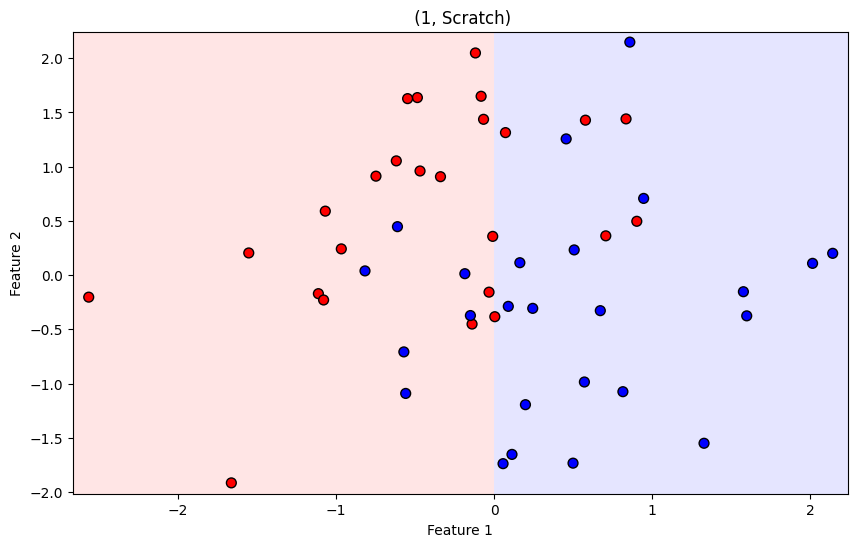

In [16]:
import matplotlib.pyplot as plt

def plot_decision_boundary_dt(model, X, y, title):

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    X_grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(X_grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    cmap_boundary = ListedColormap(['#FFAAAA', '#AAAAFF'])
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_boundary)

    cmap_points = ListedColormap(['red', 'blue'])
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=cmap_points, s=50)

    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

from matplotlib.colors import ListedColormap

print("\n--- 決定領域の可視化 (問題6) ---")

plot_decision_boundary_dt(dtc_scratch, X, y,
                           " (1, Scratch)")